In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

## Random process definition

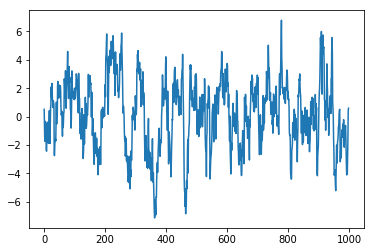

In [2]:
N = 1000
alpha = 0.9
X = []
X_actual = 0
for i in range(1,N):
    X_plus = alpha * X_actual + np.random.randn() 
    X.append(X_plus)
    X_actual = X_plus

plt.plot(X)
plt.show()

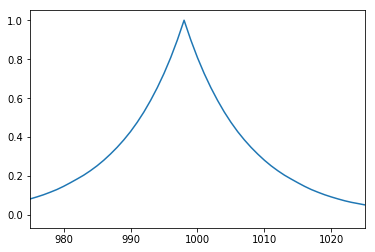

In [13]:
N = 1000
alpha = 0.9
Nrealisations = 100
R = np.zeros(2*N-3)

for j in range(Nrealisations):
    X = []
    X_actual = 0
    for i in range(1,N):
        X_plus = alpha * X_actual + np.random.randn() 
        X.append(X_plus)
        X_actual = X_plus
    R += np.correlate(X,X, mode='full')
        
R = R/Nrealisations

plt.plot(R/max(R))
plt.xlim([1000-25,1000+25])
plt.show()

In [17]:
len(R)

1997

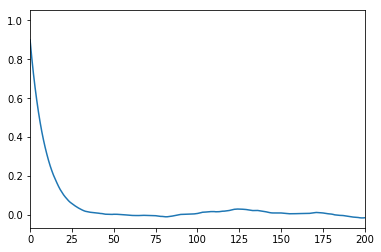

In [27]:
psd = np.fft.fftshift(R)
plt.plot(psd/max(psd))
plt.xlim([0,200])
plt.show()

 ## Wavelet packet decomposition

In [28]:
cA,cD = pywt.dwt(X, 'db1')

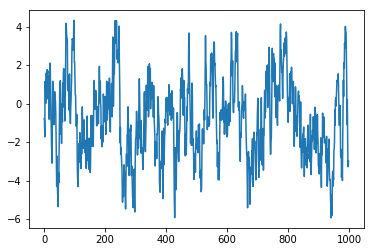

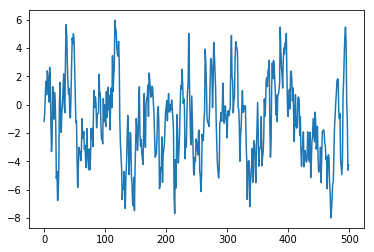

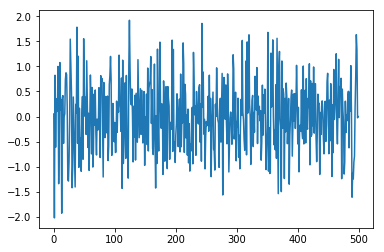

In [29]:
plt.plot(X)
plt.show()

plt.plot(cA)
plt.show()

plt.plot(cD)
plt.show()

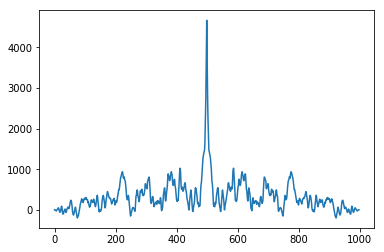

In [30]:
Rca = np.correlate(cA,cA, mode='full')

plt.plot(Rca)
plt.show()